In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import utils
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
from snntorch import functional

import matplotlib.pyplot as plt
import numpy as np

from trainer import *


d:\Program Files\Python\Python310\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:


dtype=torch.float
print("Spiking Feedforward SNN Trained on MNIST")

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Training Parameters
batch_size=256
data_path='./tmp/data/mnist'
num_classes = 10  # MNIST has 10 output classes

# Define a transform
transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

mnist_train = datasets.MNIST(data_path, train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(data_path, train=False, download=True, transform=transform)

# # temporary dataloader if MNIST service is unavailable
# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz

train_sampler = torch.utils.data.RandomSampler(mnist_train, generator=gtrain,replacement=False)
test_sampler = torch.utils.data.RandomSampler(mnist_test, generator=gtest,replacement=False)

train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=False,drop_last=True,pin_memory=True,sampler=train_sampler)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False,drop_last=True,pin_memory=True,sampler=test_sampler)

Feedforward SNN Trained on MNIST
Using device: cuda


In [3]:
################ MNIST Model ##############################################################

# layer parameters
num_inputs = 28*28
num_hidden1 = 300
num_hidden2 = 100
num_outputs = 10
num_steps = 26  # for spike encoding
beta = 0.95 #leak rate
lr=5e-3
#weight_decay=1e-6

spike_grad1 = surrogate.atan() 

class Net(nn.Module):

    def __init__(self):
        super().__init__()

        self.loss = functional.ce_count_loss()
        self.accuracy_metric = functional.accuracy_rate

        #initialise neuron connections
        self.linears = nn.ModuleList([
            nn.Linear(num_inputs, num_hidden1),
            nn.Linear(num_hidden1,num_hidden2),
            nn.Linear(num_hidden2,num_outputs)
        ])

        # initialize neurons
        self.neurons = nn.ModuleList([
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1),
            snn.Leaky(beta=beta,spike_grad=spike_grad1)
        ])


        #pytorch creates the tensors to represent the network layout and weights for each layer; snntorch provides the model that operates on the entire tensor (at each layer).

  
    def forward(self,x): #x is input data
        
        x=x.view(x.size(0), -1) #flatten image
        
        #spike encoding at input layer
        x_spk = spikegen.rate(x,num_steps=num_steps) 
        # Initialize hidden states
        mem1 = self.neurons[0].init_leaky()
        mem2 = self.neurons[1].init_leaky()
        mem3 = self.neurons[2].init_leaky()
        
        # record spike outputs and membrane potentials
        spk3_rec = []

        for step in range(num_steps):
            x = x_spk[step] #for encoded input

            cur1 = self.linears[0](x)
            spk1, mem1 = self.neurons[0](cur1, mem1)

            cur2 = self.linears[1](spk1)
            spk2, mem2 = self.neurons[1](cur2, mem2)

            cur3 = self.linears[2](spk2)
            spk3, mem3 = self.neurons[2](cur3, mem3)

            spk3_rec.append(spk3)

        return torch.stack(spk3_rec, dim=0)
    
###################################################################################



  0%|          | 0/234 [00:00<?, ?it/s]

Iteration: 0
Training loss: 2.29
Validation loss: 1.91
Validation accuracy: 36.33%
Training accuracy: 10.94
----------------
Iteration: 50
Training loss: 0.55
Validation loss: 0.42
Validation accuracy: 89.45%
Training accuracy: 82.81
----------------
Iteration: 100
Training loss: 0.24
Validation loss: 0.29
Validation accuracy: 91.02%
Training accuracy: 92.58
----------------
Iteration: 150
Training loss: 0.26
Validation loss: 0.18
Validation accuracy: 93.75%
Training accuracy: 91.41
----------------
Iteration: 200
Training loss: 0.18
Validation loss: 0.10
Validation accuracy: 97.27%
Training accuracy: 94.53
----------------


  0%|          | 0/234 [00:00<?, ?it/s]

Iteration: 250
Training loss: 0.13
Validation loss: 0.18
Validation accuracy: 94.14%
Training accuracy: 95.70
----------------
Iteration: 300
Training loss: 0.16
Validation loss: 0.20
Validation accuracy: 93.75%
Training accuracy: 95.70
----------------
Iteration: 350
Training loss: 0.07
Validation loss: 0.16
Validation accuracy: 94.53%
Training accuracy: 97.27
----------------
Iteration: 400
Training loss: 0.06
Validation loss: 0.12
Validation accuracy: 94.53%
Training accuracy: 97.66
----------------
Iteration: 450
Training loss: 0.11
Validation loss: 0.09
Validation accuracy: 97.66%
Training accuracy: 97.27
----------------


  0%|          | 0/234 [00:00<?, ?it/s]

Iteration: 500
Training loss: 0.07
Validation loss: 0.12
Validation accuracy: 97.27%
Training accuracy: 96.48
----------------
Iteration: 550
Training loss: 0.12
Validation loss: 0.19
Validation accuracy: 94.14%
Training accuracy: 94.92
----------------
Iteration: 600
Training loss: 0.25
Validation loss: 0.11
Validation accuracy: 96.88%
Training accuracy: 93.75
----------------
Iteration: 650
Training loss: 0.19
Validation loss: 0.11
Validation accuracy: 96.09%
Training accuracy: 95.70
----------------
Iteration: 700
Training loss: 0.15
Validation loss: 0.18
Validation accuracy: 94.53%
Training accuracy: 95.31
----------------


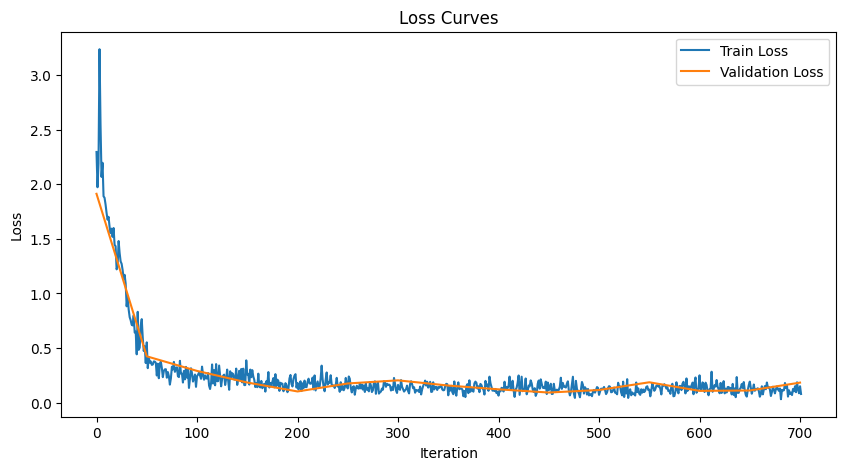

  0%|          | 0/39 [00:00<?, ?it/s]

Test Accuracy: 0.97%


In [4]:
model_path = "./models/SNN_MNIST.pt"
gen_reset()
net = trainer(Net,train_loader=train_loader,valid_loader=test_loader,model_path=model_path,lr=lr,epochs=3,iterations=None,deepr=False,device=device)
gen_reset()
test_stats(net,test_loader=test_loader,device=device)